In [22]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/zcapjru/PhD/DEScls')
from xcell.mappers import MappereBOSSQSO
from xcell.mappers import MapperP15CMBK

from astropy.io import fits
from astropy.table import Table

import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
from classy import Class
import pymc3 as pm
import theano.tensor as tt
import os
import arviz as az

In [2]:
sys.path.insert(1, '/home/zcapjru/PhD/Pk_Emulator')

import scipy
import itertools
from numpy import linalg
from sklearn.decomposition import PCA

import lin_pk_emul as emul

In [3]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
nside_mask = 512

ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)
    
if ells[-1] <  3 * nside -1:   
    ells.append(3 * nside -1)
    
ells = np.array(ells)


scale_cut = 1000
ells = ells[ells < scale_cut]

if ells[-1] < scale_cut:
    ells = np.append(ells, scale_cut)
    
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()
print(ell_arr)

[ 21.5  43.   67.   92.5 120.  150.5 183.  218.  256.5 298.  343.  391.5
 444.  501.  563.  630.  702.5 781.  866.  955. ]


In [4]:
NGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[0, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_1' }

NGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_2'  }

SGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[0.01, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1' }

SGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1'  }

CMBK_config = {'file_klm':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/dat_klm.fits', 
          'file_mask':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/mask.fits.gz',
               'file_noise':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/nlkk.dat', 'mask_name': 3,
          'nside':nside}

In [5]:
b_arr = np.linspace(0, 5, 100)
zbin = 1
mode = 'NGC'
experiments = ['gg', 'gk']
#use_emulator = True
use_toeplitz = True
cov_path = '/home/zcapjru/PhD/Covs/'
maps_k = MapperP15CMBK(CMBK_config)
maps_q = MappereBOSSQSO(NGC_1_config)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [6]:
nz = maps_q.get_nz()

z = nz[1]
dNdz = nz[0]

m_q = maps_q.get_mask()
f_q = maps_q.get_nmt_field()

w_qq = nmt.NmtWorkspace()
w_qq.compute_coupling_matrix(f_q, f_q, bands)

nl_qq =  w_qq.decouple_cell(maps_q.get_nl_coupled())

m_k = maps_k.get_mask()
f_k = maps_k.get_nmt_field()

w_kq = nmt.NmtWorkspace()
w_kq.compute_coupling_matrix(f_q, f_k, bands)

w_kk = nmt.NmtWorkspace()
w_kk.compute_coupling_matrix(f_k, f_k, bands)

In [7]:
def get_cov_wsp(f1, f2, f3 = None, f4 = None, toeplitz = False):
    cw = nmt.NmtCovarianceWorkspace()
    if toeplitz:
        cw.compute_coupling_coefficients(f1, f2, f3, f4,  l_toeplitz=345, l_exact=100, dl_band=250)
    else:
        cw.compute_coupling_coefficients(f1, f2, f3, f4)
    return cw

def get_cov(cl1, cl2, cl3, cl4, cw, wa, wb):
    return  nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      cl1,  # TT
                                      cl2,  # TT
                                      cl3,  # TT
                                      cl4,  # TT
                                      wa, wb=wb)

def build_comp_cov(cov_aaaa, cov_aaab, cov_aabb):
    cov_abaa = np.transpose(cov_aaab)
    dim = len(cov_aaaa)
    comp_cov = np.zeros([2*dim, 2*dim])
    comp_cov[:dim,:dim] = cov_aaaa
    comp_cov[:dim,dim:] = cov_aaab
    comp_cov[dim:,:dim] = cov_abaa
    comp_cov[dim:,dim:] = cov_aabb
    return comp_cov

In [8]:
fname_cov_qqqq = cov_path + 'eBOSSQSO_{}_{}_cov_qqqq_ns512.txt'.format(mode, zbin)
fname_cov_qkqk = cov_path + 'eBOSSQSOxP15CMBK_{}_{}_cov_qkqk_ns512.txt'.format(mode, zbin)
fname_cov_qqqk = cov_path + 'eBOSSQSOxP15CMBK_{}_{}_cov_qqqk_ns512.txt'.format(mode, zbin)

if os.path.isfile(fname_cov_qqqq): 
    cov_qqqq = np.loadtxt(fname_cov_qqqq)
else:
    cw_qq = get_cov_wsp(f_q, f_q, toeplitz = use_toeplitz)

    cl_qq = nmt.compute_coupled_cell(f_q, f_q)/ np.mean(m_q * m_q)
    cov_qqqq = get_cov(cl_qq, cl_qq, cl_qq, cl_qq, cw_qq, w_qq, w_qq)
    
    np.savetxt(fname_cov_qqqq, cov_qqqq)

if os.path.isfile(fname_cov_qkqk): 
    cov_qkqk = np.loadtxt(fname_cov_qkqk)
else:
    cw_qkqk = get_cov_wsp(f_q, f_k, toeplitz = use_toeplitz)
    
    cl_qk = nmt.compute_coupled_cell(f_q, f_k)/ np.mean(m_q * m_k)
    cl_kq = cl_qk
    cl_kk = nmt.compute_coupled_cell(f_k, f_k)/ np.mean(m_k * m_k)
    cov_qkqk = get_cov(cl_qq, cl_qk, cl_kq, cl_kk, cw_qkqk, w_kq, w_kq)
    np.savetxt(fname_cov_qkqk, cov_qkqk)
    
if os.path.isfile(fname_cov_qqqk): 
    cov_qqqk = np.loadtxt(fname_cov_qqqk)
else:
    cw_qqqk = get_cov_wsp(f_q, f_q, f_q, f_k, toeplitz = use_toeplitz)
    cov_qqqk = get_cov(cl_qq, cl_qk, cl_qq, cl_qk, cw_qqqk, w_qq, w_kq)
    np.savetxt(fname_cov_qqqk, cov_qqqk)

err_qk = np.sqrt(cov_qkqk.diagonal())
err_qq = np.sqrt(cov_qqqq.diagonal())

In [9]:
cl_qq = w_qq.decouple_cell(nmt.compute_coupled_cell(f_q, f_q))[0] - nl_qq[0]
cl_qk = w_kq.decouple_cell(nmt.compute_coupled_cell(f_q, f_k))[0] 

In [10]:
comp_cov = build_comp_cov(cov_qqqq, cov_qqqk, cov_qkqk)

In [11]:
class lkl(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        """
        
        self.cl_qq = cl_qq
        self.cl_qk = cl_qk
        self.data = np.zeros(2*len(self.cl_qq))
        self.mcmc_record = []
        
        cov = comp_cov
        self.icov = np.linalg.inv(cov)
        print('cov inverted')
            
        print('Likelihoood initialized')

    def likelihood(self, theta):
        
        Omega_c, h, beta = theta
        th_vector = np.zeros(len(self.data))
        
        try:
            cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=0.045, h=h, sigma8=0.78, n_s=0.96,
                                      transfer_function='boltzmann_class')
            b = beta*np.ones(len(z))
            
            if 'gg' in experiments:
                self.data[:len(cl_qq)] =  self.cl_qq
                quasar = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, dNdz),
                                            bias=(z,b))
                clgg = ccl.angular_cl(cosmo, quasar, quasar, ell_arr)
                th_vector[:len(clgg)] = clgg
            
            if 'gk' in experiments:
                self.data[len(cl_qq):] =  self.cl_qk
                CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)
                clgk = ccl.angular_cl(cosmo, quasar, CMB_shear, ell_arr)
                th_vector[len(clgk):] = clgk
                
        except Exception as e:
            return -np.inf
        
        #logl = -0.5
        logl = -0.5 * np.transpose(self.data-th_vector)@self.icov@(self.data-th_vector)
        return logl

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta)
        self.mcmc_record.append(np.append([logl],theta))

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [12]:
logl = lkl()

with pm.Model() as model:
    # uniform priors on m and c
    beta = pm.Uniform("beta", 0, 5)
    Omega_c = pm.Uniform('Omega_c', 0, 0.5)
    h = pm.Uniform('h', 0.6, 0.85)
    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([Omega_c, h, beta],ndim=3)

    # use a DensityDist (use a lamdba function to "call" the Op)
    #pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    pm.Potential('like', logl(theta))

cov inverted
Likelihoood initialized


In [13]:
#Make posteriors
with model:
    #step = pm.NUTS()
    step = pm.Metropolis()
    start = {'beta': 1.5, 'Omega_c':.3, 'h': 0.67}
    trace = pm.sample(10, tune=5, step=step, start=start, chains = 1, discard_tuned_samples=True)
    #trace = pm.sample(10, tune=5, init=None, step=step, cores=2)

Only 10 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [h]
>Metropolis: [Omega_c]
>Metropolis: [beta]


Sampling 1 chain for 5 tune and 10 draw iterations (5 + 10 draws total) took 295 seconds.
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/arviz/data/base.py:148: UserWarning: More chains (10) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/pymc3/sampling.py:628: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn(


In [29]:
np.array(logl.mcmc_record)

array([[-4.66996154e+01,  2.50000000e-01,  7.25000000e-01,
         2.50000000e+00],
       [-3.19457527e+01,  3.00000000e-01,  6.58973882e-01,
         1.50000000e+00],
       [-3.22789296e+01,  3.00000000e-01,  6.70000000e-01,
         1.50000000e+00],
       [-3.46769665e+01,  3.61953316e-01,  6.58973882e-01,
         1.50000000e+00],
       [-3.19457527e+01,  3.00000000e-01,  6.58973882e-01,
         1.50000000e+00],
       [-8.31911210e+01,  3.00000000e-01,  6.58973882e-01,
         2.80886612e+00],
       [-3.19457527e+01,  3.00000000e-01,  6.58973882e-01,
         1.50000000e+00],
       [-3.20596857e+01,  3.00000000e-01,  6.62735067e-01,
         1.50000000e+00],
       [-3.19457527e+01,  3.00000000e-01,  6.58973882e-01,
         1.50000000e+00],
       [-2.56463484e+01,  1.83857322e-01,  6.62735067e-01,
         1.50000000e+00],
       [-3.20596857e+01,  3.00000000e-01,  6.62735067e-01,
         1.50000000e+00],
       [-4.58185829e+01,  1.83857322e-01,  6.62735067e-01,
      

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/arviz/data/base.py:148: UserWarning: More chains (10) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/arviz/data/base.py:148: UserWarning: Mor

,mean,sd,hdi_3%,hdi_97%
beta,1.87,0.02,1.85,1.91
Omega_c,0.20,0.02,0.17,0.21
h,0.70,0.03,0.65,0.77


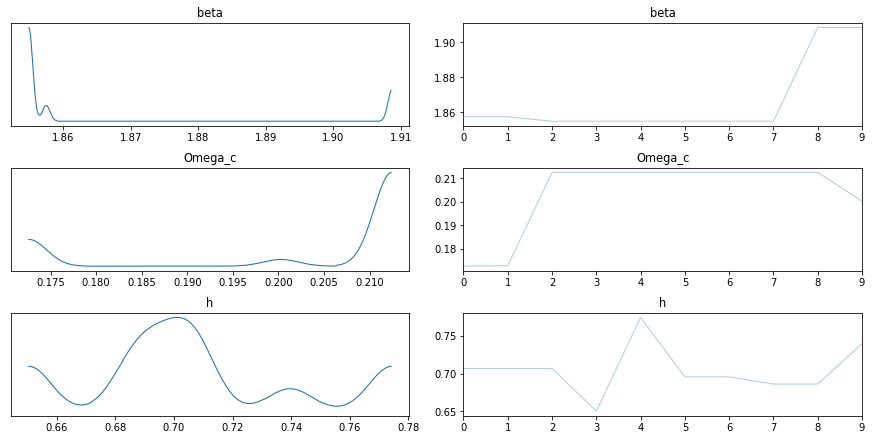

In [23]:
# plot the traces
pm.traceplot(trace)
display(az.summary(trace, kind="stats", round_to=2))

In [27]:
trace['beta']

array([1.85744555, 1.85744555, 1.85490189, 1.85490189, 1.85490189,
       1.85490189, 1.85490189, 1.85490189, 1.90857819, 1.90857819])

In [24]:
trace['accepted']

array([[ True,  True,  True],
       [False,  True, False],
       [False,  True,  True],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True,  True, False]])

In [ ]:
best_b = best_b*np.ones(len(z))

quasar = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,best_b))
CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)

theory_qq = ccl.angular_cl(cosmo, quasar, quasar, ell_arr)
theory_qk = ccl.angular_cl(cosmo, CMB_shear, quasar, ell_arr)

In [ ]:
plt.errorbar(ell_arr, cl_qq, yerr=err_qq, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, nl_qq[0], 'go-', label='Noise')
plt.plot(ell_arr, theory_qq, 'r--', label='Best theory')


#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('{}_{}{}'.format(mode, zbin, zbin))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, (theory_qq-cl_qq)/err_qq, 'ro-', label=r'$\frac{t-d}{\sigma}$')
#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('Residuals {}_{}{}'.format(mode, zbin, zbin))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.errorbar(ell_arr, cl_qk, yerr=err_qk, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, theory_qk, 'r--', label='Best theory')


plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('{}_{}{}'.format(mode, zbin, 'k'))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, (theory_qk-cl_qk)/err_qk, 'ro-', label=r'$\frac{t-d}{\sigma}$')

#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('Residuals {}_{}{}'.format(mode, zbin, 'k'))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(b_arr, pb, 'r-', label='P(b)')
plt.text(0, 0.09, 'best b ='+'{}'.format(best_b[0]))
plt.text(0, 0.07, r'$\bar{b}$ ='+'{}'.format(mean_b))
plt.text(0, 0.05, r'$\sigma b$ ='+'{}'.format(sigma_b))
plt.text(0, 0.03, r'$\chi^2$ ='+'{}'.format(best_x2))
plt.title('{}_{}+Shear'.format(mode, zbin))
plt.xlabel('$b$', fontsize=16)
plt.ylabel('$P(b)$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()